In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

import seaborn as sns

import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-temperature-of-major-cities/city_temperature.csv


## Data


In [2]:
csv_data = pd.read_csv("/kaggle/input/daily-temperature-of-major-cities/city_temperature.csv")
csv_data.describe

/tmp/ipykernel_36/674508825.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_data = pd.read_csv("/kaggle/input/daily-temperature-of-major-cities/city_temperature.csv")


<bound method NDFrame.describe of                 Region  Country                   State                  City  \
0               Africa  Algeria                     NaN               Algiers   
1               Africa  Algeria                     NaN               Algiers   
2               Africa  Algeria                     NaN               Algiers   
3               Africa  Algeria                     NaN               Algiers   
4               Africa  Algeria                     NaN               Algiers   
...                ...      ...                     ...                   ...   
2906322  North America       US  Additional Territories  San Juan Puerto Rico   
2906323  North America       US  Additional Territories  San Juan Puerto Rico   
2906324  North America       US  Additional Territories  San Juan Puerto Rico   
2906325  North America       US  Additional Territories  San Juan Puerto Rico   
2906326  North America       US  Additional Territories  San Juan Puerto Ri

In [3]:
alg_data = csv_data[csv_data["Country"]=="Algeria"]

In [4]:
data = alg_data.iloc[:, -4:]

In [5]:
def fahrenheit_to_celsius(fahrenheit):
    celsius = (fahrenheit - 32) / 1.8
    return celsius


In [6]:
data["temp_c"] = data["AvgTemperature"].apply(fahrenheit_to_celsius)
data = data[data['temp_c'] >= 0]
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

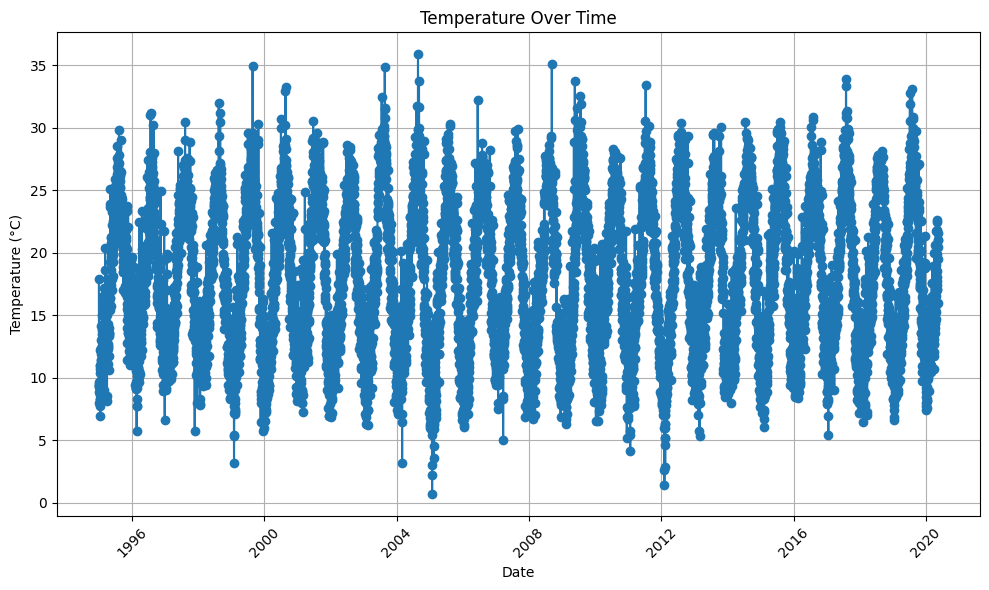

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['temp_c'], marker='o')

# Adding title and labels
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')

# Displaying the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
data['temp_c_scaled'] = scaler.fit_transform(data[['temp_c']])

In [9]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data.iloc[i:(i + sequence_length)].temp_c_scaled.values
        y = data.iloc[i + sequence_length].temp_c_scaled
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 10
X, y = create_sequences(data, sequence_length)

In [10]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [39]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = model.fit(X_train, y_train,validation_split =0.2, batch_size=1, epochs=5)

Epoch 1/5
5900/5900 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.0063 - val_loss: 0.0028
Epoch 2/5
5900/5900 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 3/5
5900/5900 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 4/5
5900/5900 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 5/5
5900/5900 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 0.0028 - val_loss: 0.0022


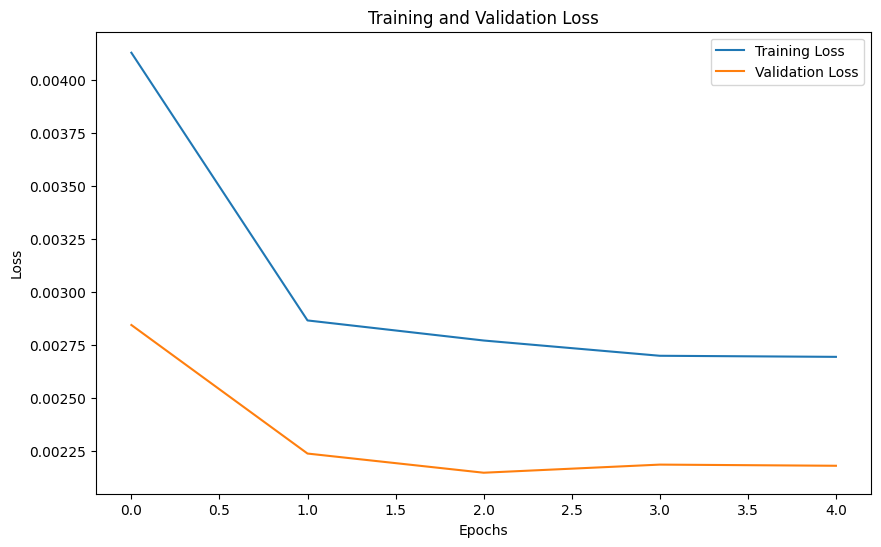

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform([y_test])

y_train_actual = scaler.inverse_transform([y_train])

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


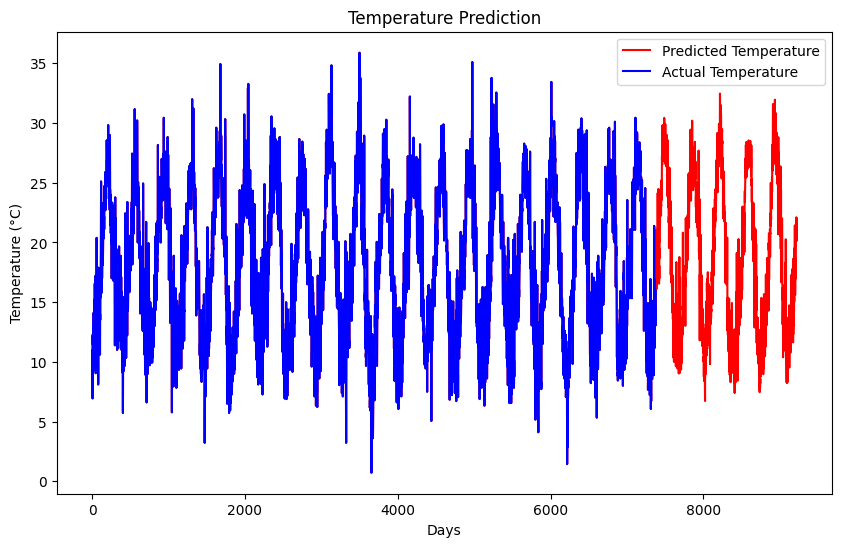

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(np.concatenate([y_train_actual.reshape(-1),predictions.reshape(-1) ]), color='red', label='Predicted Temperature')
plt.plot(y_train_actual.reshape(-1), color='blue', label='Actual Temperature')

plt.title('Temperature Prediction')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()